# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Examining Explained Variance of Principal Component Analysis around Yield Changes during FOMC meetings

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerPatch

from FOMCDataPrep import DataPrep
from sklearn.decomposition import PCA

Access ```BBGEventCollect``` module

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\BBGEvent\root")
from BBGEventCollect import BBGCollect

In [3]:
def prep_yields() -> pd.DataFrame: 

    df_yield = (DataPrep().get_tsy_yields().reset_index().rename(
        columns = {"DATE": "Date"}).
        assign(Date = lambda x: pd.to_datetime(x.Date).dt.date).
        melt(id_vars = "Date").
        dropna())
    
    return df_yield

df_yield = prep_yields()

Searching for Treasury data
Found Data


In [4]:
def prep_nlp() -> pd.DataFrame: 
    
    df_nlp = (DataPrep().get_labor_sentiment().reset_index().rename(
        columns = {"date": "Date"}).
        assign(Date = lambda x: pd.to_datetime(x.Date).dt.date))
    
    return df_nlp

df_nlp = prep_nlp()

Searching for Labor Data
Found Data


In [5]:
def _get_order(df: pd.DataFrame, before: float, after: float) -> pd.DataFrame: 
    
    try: 
    
        df_out = (df.sort_values(
            "Date").
            assign(order = [i for i in range(before, after + 1)]))
        
        return df_out
    
    except:  pass

def get_window_ordered(before: int = -1, after: int = 1) -> pd.DataFrame: 
    
    df_dates = BBGCollect()._get_days_window(ticker = "FDTR", before = before, after = after)

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row
        df_tmp = (df_yield.query(
            "@start_date <= Date <= @end_date").
            groupby("variable").
            apply(_get_order, before, after).
            reset_index(drop = True))

        df_combined = (pd.concat(
            [df_combined, df_tmp]).
            groupby(["Date", "variable"]).
            head(1))

    return df_combined

In [6]:
def get_ordered_changes(df_yield: pd.DataFrame, begin: float = -6, end: float = 1) -> pd.DataFrame: 

    df_ordered = (df_yield.pivot(
        index = "Date", columns = "variable", values = "value").
        diff().
        reset_index().
        melt(id_vars = "Date").
        rename(columns = {"value": "yield_diff"}).
        merge(
            right = get_window_ordered(before = begin, after = end), 
            how = "inner", 
            on = ["Date", "variable"]).
        drop(columns = ["value"]).
        rename(columns = {"yield_diff": "value"}))
    
    return df_ordered

df_ordered = get_ordered_changes(df_yield)

In [7]:
def _get_pc_importance(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.drop(
        columns = ["order"]).
        pivot(index = "Date", columns = "variable", values = "value").
        diff().
        dropna())
    
    exp_variance = PCA(n_components = 3).fit(df_tmp).explained_variance_ratio_
    
    df_out = (pd.DataFrame().assign(
        PC = [i + 1 for i in range(len(exp_variance))],
        exp_variance = exp_variance))
    
    return df_out

def get_pc_importance(df_ordered: pd.DataFrame) -> pd.DataFrame: 

    df_pc = (df_ordered.groupby(
        "order").
        apply(_get_pc_importance).
        reset_index().
        drop(columns = ["level_1"]).
        pivot(index = "order", columns = "PC", values = "exp_variance"))
    
    return df_pc

df_pc = get_pc_importance(df_ordered)

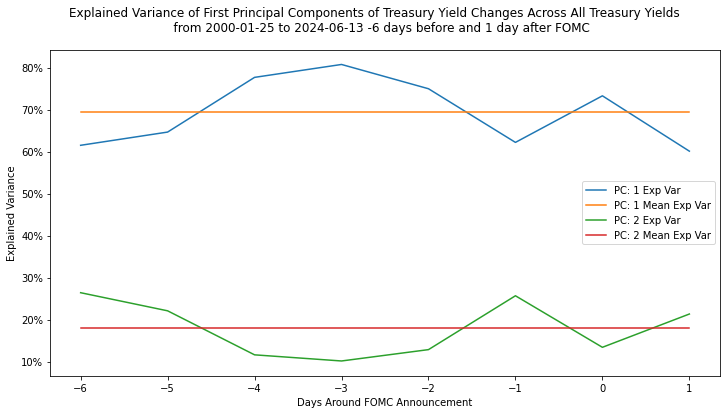

In [8]:
def plot_explained_variance(
    df_pc: pd.DataFrame, 
    df_ordered: pd.DataFrame, 
    pcs: list = [1,2]) -> plt.Figure:
    
    df_longer = (df_pc.drop(
        columns = [3]).
        reset_index().
        melt(id_vars = "order"))

    df_plot = (df_longer.drop(
        columns = ["order"]).
        groupby("PC").
        agg("mean").
        rename(columns = {"value": "mean_exp"}).
        merge(right = df_longer, how = "inner", on = ["PC"]))

    fig, axes = plt.subplots(figsize = (12,6))
    for pc in pcs: 

        df_tmp = (df_plot.query(
            "PC == @pc").
            drop(columns = ["PC"]).
            rename(columns = {"value": "exp_var"}).
            melt(id_vars = "order").
            assign(variable = lambda x: np.where(
                x.variable == "mean_exp", 
                "PC: " + str(pc) + " Mean Exp Var", 
                "PC: " + str(pc) + " Exp Var")).
            pivot(index = "order", columns = "variable", values = "value"))

        df_tmp.plot(
            ax = axes,
            ylabel = "Explained Variance",
            xlabel = "Days Around FOMC Announcement")

    axes.legend(title = "")
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    fig.suptitle('''Explained Variance of First Principal Components of Treasury Yield Changes Across All Treasury Yields
    from {} to {} -6 days before and 1 day after FOMC'''.format(
        df_ordered.Date.min(),
        df_ordered.Date.max()))
    
plot_explained_variance(df_pc, df_ordered)

In [9]:
def _fomc_meeting_count(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "Date").
        assign(meeting = lambda x: x.meeting.fillna(method = "ffill")))
    
    return df_out

def get_fomc_meeting_count(df: pd.DataFrame) -> pd.DataFrame: 

    df_min = (df.query(
        "order == order.min()")
        [["Date"]].
        drop_duplicates())

    df_out = (df_min.assign(
        meeting = [i + 1 for i in range(len(df_min))]).
        merge(right = df_ordered, how = "outer", on = ["Date"]).
        groupby("variable").
        apply(_fomc_meeting_count).
        reset_index(drop = True))
    
    return df_out

df_meeting_count = get_fomc_meeting_count(df_ordered)

In [10]:
def _fill_benlpfed(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "BENLPFED").
        assign(BENLPFED = lambda x: x.BENLPFED.fillna(method = "ffill")))
    
    return df_out

def combine_benlpfed_meeting_count(df_meeting_count: pd.DataFrame, df_nlp: pd.DataFrame) -> pd.DataFrame: 

    start_date = df_nlp.Date.min()
    df_out = (df_meeting_count.query(
        "order == -3")
        [["Date", "order"]].
        drop_duplicates().
        merge(right = df_nlp, how = "inner", on = ["Date"]).
        merge(right = df_meeting_count, how = "outer", on = ["Date", "order"]).
        query("Date >= @start_date").
        assign(group_var = lambda x: x.variable + "_" + x.meeting.astype(str)).
        groupby("group_var").
        apply(_fill_benlpfed).
        reset_index(drop = True).
        drop(columns = ["group_var"]).
        assign(sentiment = lambda x: np.where(x.BENLPFED < 0, "Negative", "Positive")))
    
    return df_out

df_nlp_meeting = combine_benlpfed_meeting_count(df_meeting_count, df_nlp)

In [11]:
def get_pc_sentiment(df_nlp_meeting: pd.DataFrame) -> pd.DataFrame: 
    
    df_sentiment_pc = (df_nlp_meeting.groupby(
        "sentiment").
        apply(get_pc_importance).
        reset_index())
    
    return df_sentiment_pc

df_sentiment_pc = get_pc_sentiment(df_nlp_meeting)

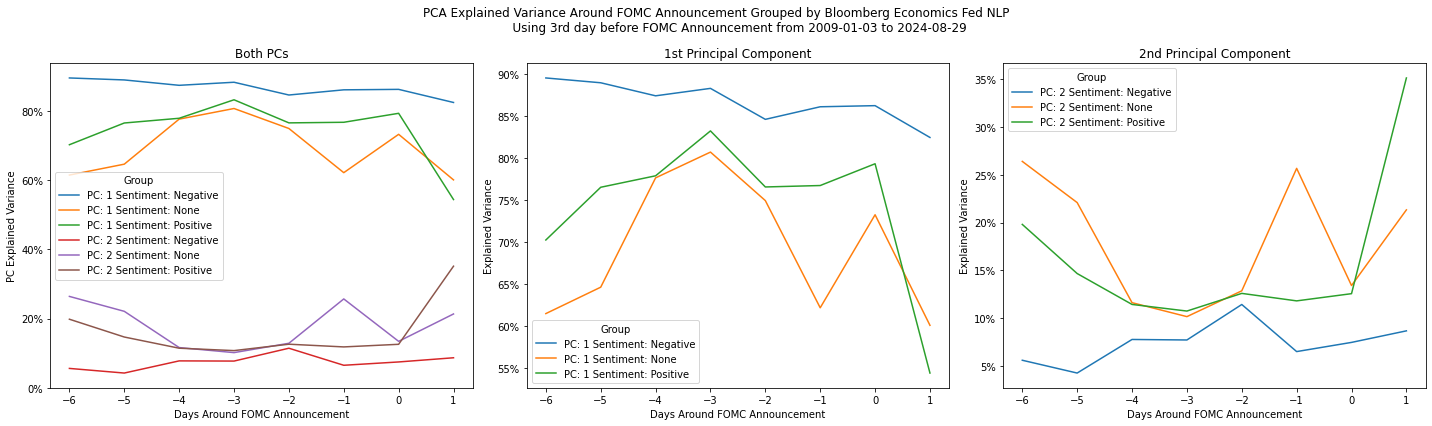

In [12]:
def plot_sentiment_pc(df_sentiment_pc: pd.DataFrame, df_pc: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

    df_none = (df_pc.reset_index().melt(
        id_vars = "order").
        query("PC != 3").
        assign(
            sentiment = "None",
            Group = lambda x: "PC: " + x.PC.astype(str) + " Sentiment: None"))

    df_longer = (df_sentiment_pc.drop(
        columns = [3]).
        melt(id_vars = ["sentiment", "order"]).
        assign(name = lambda x: "PC: " + x.PC.astype(str) + " Sentiment: " + x.sentiment).
        rename(columns = {"name": "Group"}))

    df_plot = pd.concat([df_longer, df_none])

    (df_plot[
        ["order", "Group", "value"]].
        pivot(index = "order", columns = "Group", values = "value").
        plot(
            xlabel = "Days Around FOMC Announcement",
            ax = axes[0],
            ylabel = "PC Explained Variance",
            title = "Both PCs"))

    PCS_dict = {
        1: "1st Principal Component",
        2: "2nd Principal Component"}
    
    for PC in PCS_dict.keys():

        (df_plot.query(
            "PC == @PC")
            [["order", "value", "Group"]].
            pivot(index = "order", columns = "Group", values = "value").
            plot(
                title = PCS_dict[PC],
                ylabel = "Explained Variance",
                xlabel = "Days Around FOMC Announcement",
                ax = axes[PC]))

    for ax in axes.flatten(): ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.suptitle('''PCA Explained Variance Around FOMC Announcement Grouped by Bloomberg Economics Fed NLP
            Using 3rd day before FOMC Announcement from {} to {}'''.format(
                df_nlp.Date.min(),
                df_nlp.Date.max()))

    plt.tight_layout()
    
plot_sentiment_pc(df_sentiment_pc, df_pc)